TODO:

- Increase the number of epochs at 200
- Implement EarlyStopping in KerasClassifier
- Consider lower values of lambda (0.001)

- For emotion classification:
  - SGD with 1 hidden layer
  - SGD with an 2 hidden layers
  - Adam with 2 hidden layers
  - Dropout with 2 hidden layers

# **Imports**

In [2]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.regularizers import L1, L2
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [4]:
# setting plots style
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

# **Data** **Preparation**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_train = pd.read_csv('/content/drive/My Drive/df_train_processed.csv')
df_test = pd.read_csv('/content/drive/My Drive/df_test_processed.csv')

In [7]:
df_train.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,frame_count,sum,mean,...,stft_std_w4,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,speech,neutral,normal,Kids are talking by the door,1st,1,M,158558,0.145081,9.150000e-07,...,0.155455,0.000000,0.000000,0.566462,0.709962,0.799141,0.896606,1.0,6.742190,-1.706215
1,speech,neutral,normal,Kids are talking by the door,2nd,1,M,160160,0.114319,7.137790e-07,...,0.163183,0.270133,0.368623,0.472736,0.623183,0.744908,0.874713,1.0,-0.700420,-0.201495
2,speech,neutral,normal,Dogs are sitting by the door,1st,1,M,156956,0.149963,9.554485e-07,...,0.190634,0.000000,0.000000,0.417919,0.643636,0.774253,0.899156,1.0,1.688986,-1.024773
3,speech,neutral,normal,Dogs are sitting by the door,2nd,1,M,152152,0.139618,9.176213e-07,...,0.182551,0.205616,0.306280,0.399641,0.606910,0.755213,0.886474,1.0,-0.594111,-0.412871
4,speech,calm,normal,Kids are talking by the door,1st,1,M,169769,0.137665,8.108948e-07,...,0.177069,0.177847,0.248765,0.428202,0.634815,0.759914,0.878014,1.0,0.126535,-0.620782


In [8]:
df_test.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,frame_count,sum,mean,...,stft_std_w4,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,speech,neutral,normal,Kids are talking by the door,1st,19,M,161762,0.475616,2.940224e-06,...,0.169929,0.222808,0.306697,0.466157,0.645931,0.789123,0.908316,1.0,-0.260279,-0.566556
1,speech,neutral,normal,Kids are talking by the door,2nd,19,M,155355,0.120148,7.733752e-07,...,0.216928,0.114567,0.170786,0.279347,0.557524,0.733053,0.866973,1.0,-0.428900,-0.587210
2,speech,neutral,normal,Dogs are sitting by the door,1st,19,M,160160,-0.599304,-3.741909e-06,...,0.227178,0.010295,0.023285,0.305395,0.577750,0.741576,0.889984,1.0,0.626916,-0.883317
3,speech,neutral,normal,Dogs are sitting by the door,2nd,19,M,158558,-0.080383,-5.069646e-07,...,0.179467,0.241405,0.368081,0.434591,0.620144,0.776419,0.904668,1.0,-0.825144,-0.383701
4,speech,calm,normal,Kids are talking by the door,1st,19,M,176176,0.152222,8.640319e-07,...,0.189124,0.217860,0.298851,0.393112,0.623309,0.772964,0.907035,1.0,-0.536669,-0.547354


In [9]:
print(df_train.shape, df_test.shape)

(1828, 383) (624, 383)


In [10]:
# standardization (train)
df_train_num = df_train.select_dtypes(include="number").drop("actor", axis=1)
df_train_cat = df_train.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train = pd.concat([df_train_num_scaled, df_train_cat], axis=1)

In [11]:
# standardization (test)
df_test_num = df_test.select_dtypes(include="number").drop("actor", axis=1)
df_test_cat = df_test.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_test_num_scaled = pd.DataFrame(scaler.fit_transform(df_test_num), columns=df_test_num.columns)
df_test = pd.concat([df_test_num_scaled, df_test_cat], axis=1)

In [12]:
print(df_train.shape, df_test.shape)

(1828, 382) (624, 382)


# **Keras**

###Methods

In [13]:
# function to create accuracy and loss plots
def plot_acc_loss(train_scores, val_scores, train_loss, val_loss):
  plt.plot(train_scores, label='TR')
  plt.plot(val_scores, label='VL', linestyle='--')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  plt.plot(train_loss, label='TR')
  plt.plot(val_loss, label='VL', linestyle='--')
  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend(loc='upper right')
  plt.show()

In [14]:
# function to transform continuous output from sigmoid into binary output

def get_pred_sigmoid(predictions):
  y_pred = np.zeros(len(predictions))
  for i in range(len(predictions)):  
    if predictions[i] > .5:
      y_pred[i] = 1
    else:
      y_pred[i] = 0

  return y_pred

In [15]:
# function to select the index with max probability from softmax output

def get_pred_softmax(predictions):
  preds = [list(pred).index(max(pred)) for pred in predictions] 
  return np.array(preds)

###**Target: Vocal Channel**

#### Data Preparation

In [51]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "song":
      new_array[i] = 1
  return new_array

In [52]:
X_train = df_train.drop("vocal_channel", axis=1)
X_train = pd.get_dummies(X_train).to_numpy() #one-hot encoding + conversion into np array
y_train = label_encoder(df_train["vocal_channel"])

In [53]:
X_test = df_test.drop("vocal_channel", axis=1)
X_test = pd.get_dummies(X_test).to_numpy() #one-hot encoding + conversion into np array
y_test = label_encoder(df_test["vocal_channel"])

In [54]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1828, 392) (1828,)
(624, 392) (624,)


In [55]:
# splitting VL
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, stratify=y_train, random_state=10)

In [56]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1279, 392) (1279,)
(549, 392) (549,)


####Model

In [227]:
# function to be passed to scikeras wrapper
def build_fn(n_hidden_units, hidden_activation, learning_rate, momentum, regularizer, lambd, initializer, output_activation): 
    keras.backend.clear_session()
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(n_hidden_units, 
                    activation = hidden_activation, 
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  regularizer(lambd),
                    kernel_initializer = initializer))
    
    model.add(Dense(1, 
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = SGD(learning_rate = learning_rate, momentum = momentum),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [228]:
# randomized search
model = KerasClassifier(build_fn,
                        hidden_activation = "sigmoid",
                        regularizer=L2,
                        initializer="glorot_normal",
                        output_activation="sigmoid",
                        random_state=42,
                        batch_size=32,
                        verbose=0
                        )

param_grid = {'model__n_hidden_units': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__momentum': [0, .001, .01, .1],
              'model__lambd': [0, .001, .01, .1],
              'epochs': [10, 20, 50, 100, 200]
              }

search = RandomizedSearchCV(model, 
                            param_grid, 
                            cv=StratifiedKFold(5, shuffle=True, random_state=42), 
                            verbose=1,
                            n_iter=50,
                            #n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train, y_train, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.9874197170446891 
Best params {'model__n_hidden_units': 32, 'model__momentum': 0.01, 'model__learning_rate': 1, 'model__lambd': 0, 'epochs': 200}


In [232]:
keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(32, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 1, momentum = 0.01),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                12576     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,609
Trainable params: 12,609
Non-trainable params: 0
_________________________________________________________________


In [233]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=True)

history = model.fit(X_train2, y_train2, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/200
40/40 [==============================] - 1s 10ms/step - loss: 0.6811 - accuracy: 0.6560 - val_loss: 0.6525 - val_accuracy: 0.5902
Epoch 2/200
40/40 [==============================] - 0s 4ms/step - loss: 0.4875 - accuracy: 0.7686 - val_loss: 0.1984 - val_accuracy: 0.9526
Epoch 3/200
40/40 [==============================] - 0s 4ms/step - loss: 0.4210 - accuracy: 0.8389 - val_loss: 0.2414 - val_accuracy: 0.9016
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.2549 - accuracy: 0.9046 - val_loss: 0.1427 - val_accuracy: 0.9508
Epoch 5/200
40/40 [==============================] - 0s 4ms/step - loss: 0.2189 - accuracy: 0.9249 - val_loss: 0.1132 - val_accuracy: 0.9636
Epoch 6/200
40/40 [==============================] - 0s 4ms/step - loss: 0.1662 - accuracy: 0.9343 - val_loss: 0.1337 - val_accuracy: 0.9545
Epoch 7/200
40/40 [==============================] - 0s 4ms/step - loss: 0.1417 - accuracy: 0.9523 - val_loss: 0.0917 - val_accuracy: 0.9672
Epoch 8/200


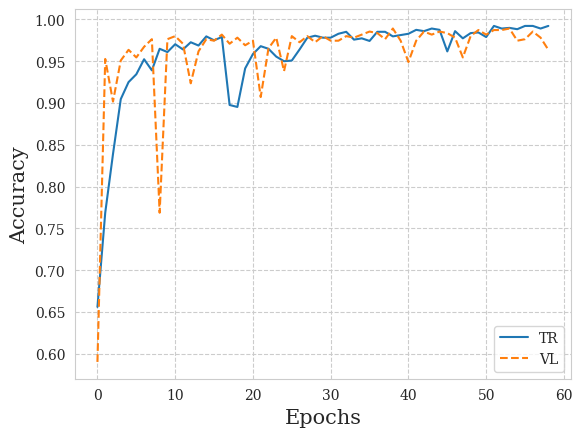

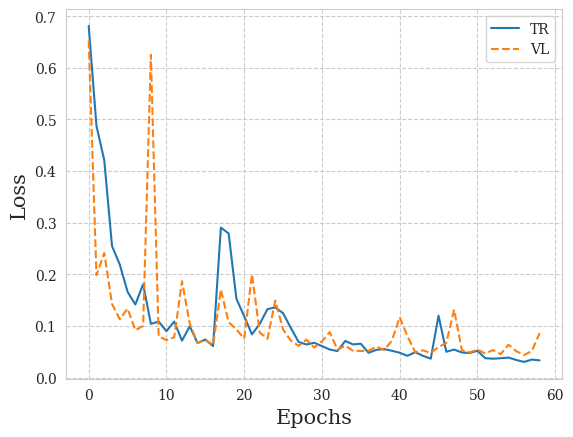

In [234]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [235]:
# performance on validation
y_pred = get_pred_sigmoid(model.predict(X_val))
print(classification_report(y_val, y_pred))

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       324
         1.0       0.93      0.99      0.96       225

    accuracy                           0.96       549
   macro avg       0.96      0.97      0.96       549
weighted avg       0.97      0.96      0.96       549



In [237]:
# retrain on all data (X_train) 

keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(32, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 1, momentum = 0.01),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

history = model.fit(X_train, y_train, epochs=59, batch_size=32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                12576     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,609
Trainable params: 12,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/59
58/58 [==============================] - 2s 10ms/step - loss: 0.6906 - accuracy: 0.6187
Epoch 2/59
58/58 [==============================] - 0s 7ms/step - loss: 0.4353 - accuracy: 0.8036
Epoch 3/59
58/58 [==============================] - 1s 9ms/step - loss: 0.2171 - accuracy: 0.9136
Epoch 4/59
58/58 [==============================] - 0s 7ms/step - loss: 0.1966 - accuracy: 0.9240
Epoch 5/59
58/58 [==============================] - 0s 

In [238]:
# performance on test with train
y_pred = get_pred_sigmoid(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       360
         1.0       0.97      0.98      0.98       264

    accuracy                           0.98       624
   macro avg       0.98      0.98      0.98       624
weighted avg       0.98      0.98      0.98       624



20/20 [==============================] - 0s 2ms/step


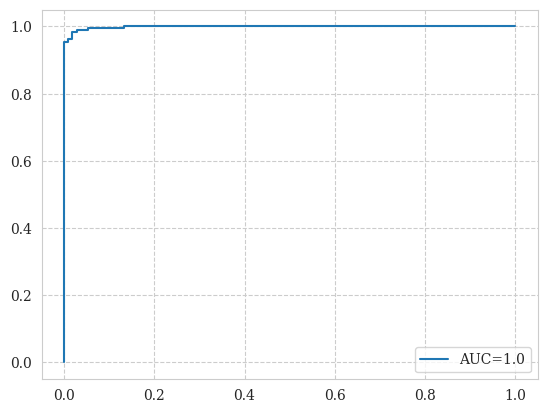

In [239]:
# ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.legend(loc=4)
plt.show()

#### Retraining on random weight initalizations 

In [58]:
accs = []
f1s = []
iter = 1
for i in random.sample(range(100), 10):
    print(f"Random weight initialization {iter}/10")
    keras.backend.clear_session()
    tf.random.set_seed(i)

    model = Sequential()
    model.add(Dense(32, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
    model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

    model.compile(optimizer = SGD(learning_rate = 1, momentum = 0.01),
                      loss = "binary_crossentropy",
                      metrics = ["accuracy"])
    
    model.fit(X_train, y_train, epochs=54, batch_size=32, verbose=0)
    y_pred = get_pred_sigmoid(model.predict(X_test))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accs.append(acc)
    f1s.append(f1)
    iter += 1

print(f"\nAvg Accuracy: {np.mean(accs)}", f"Std Accuracy: {np.std(accs)}")
print(f"Avg Wt. F1: {np.mean(f1s)}", f"Std Wt. F1: {np.std(accs)}")

Random weight initialization 1/10
20/20 [==============================] - 0s 1ms/step
Random weight initialization 2/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 3/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 4/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 5/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 6/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 7/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 8/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 9/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 10/10
20/20 [==============================] - 0s 2ms/step

Avg Accuracy: 0.975 Std Accuracy: 0.006297077789868087
Avg Wt. F1: 0.9750511935288507 Std Wt. F1: 0.006297077789868087


###**Target: Sex**

#### Data Preparation

In [42]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "M":
      new_array[i] = 1
  return new_array

In [43]:
X_train = df_train.drop("sex", axis=1)
X_train = pd.get_dummies(X_train).to_numpy() #one-hot encoding + conversion into np array
y_train = label_encoder(df_train["sex"])

In [44]:
X_test = df_test.drop("sex", axis=1)
X_test = pd.get_dummies(X_test).to_numpy() #one-hot encoding + conversion into np array
y_test = label_encoder(df_test["sex"])

In [45]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1828, 392) (1828,)
(624, 392) (624,)


In [46]:
# splitting VL
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=12)

In [47]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 392) (1462,)
(366, 392) (366,)


####Model

In [158]:
# function to be passed to scikeras wrapper

def build_fn(n_hidden_units, hidden_activation, learning_rate, momentum, regularizer, lambd, initializer, output_activation): 
    keras.backend.clear_session()
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(n_hidden_units, 
                    activation = hidden_activation, 
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  regularizer(lambd),
                    kernel_initializer = initializer))
    
    model.add(Dense(1, 
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = SGD(learning_rate = learning_rate, momentum = momentum),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [159]:
# randomized search
model = KerasClassifier(build_fn,
                        hidden_activation = "sigmoid",
                        regularizer=L2,
                        initializer="glorot_normal",
                        output_activation="sigmoid",
                        random_state=42,
                        batch_size=32,
                        verbose=0
                        )

param_grid = {'model__n_hidden_units': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__momentum': [0, .001, .01, .1],
              'model__lambd': [0, .001, .01, .1],
              'epochs': [10, 20, 50, 100, 200]
              }

search = RandomizedSearchCV(model, 
                            param_grid, 
                            cv=StratifiedKFold(5, shuffle=True, random_state=42), 
                            verbose=1,
                            n_iter=50,
                            #n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train, y_train, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.9792185043790702 
Best params {'model__n_hidden_units': 4, 'model__momentum': 0.001, 'model__learning_rate': 0.1, 'model__lambd': 0.001, 'epochs': 100}


In [200]:
keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(4, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0.001)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 0.1, momentum = 0.001),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 1572      
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,577
Trainable params: 1,577
Non-trainable params: 0
_________________________________________________________________


In [201]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=True)

history = model.fit(X_train2, y_train2, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/100
46/46 [==============================] - 2s 14ms/step - loss: 0.6857 - accuracy: 0.6135 - val_loss: 0.6512 - val_accuracy: 0.7268
Epoch 2/100
46/46 [==============================] - 1s 14ms/step - loss: 0.6263 - accuracy: 0.7900 - val_loss: 0.5842 - val_accuracy: 0.9016
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: 0.5597 - accuracy: 0.8700 - val_loss: 0.5064 - val_accuracy: 0.9262
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: 0.4905 - accuracy: 0.8865 - val_loss: 0.4325 - val_accuracy: 0.9262
Epoch 5/100
46/46 [==============================] - 0s 8ms/step - loss: 0.4287 - accuracy: 0.9008 - val_loss: 0.3724 - val_accuracy: 0.9454
Epoch 6/100
46/46 [==============================] - 0s 10ms/step - loss: 0.3768 - accuracy: 0.9029 - val_loss: 0.3241 - val_accuracy: 0.9454
Epoch 7/100
46/46 [==============================] - 0s 8ms/step - loss: 0.3402 - accuracy: 0.9056 - val_loss: 0.2868 - val_accuracy: 0.9399
Epoch 8/10

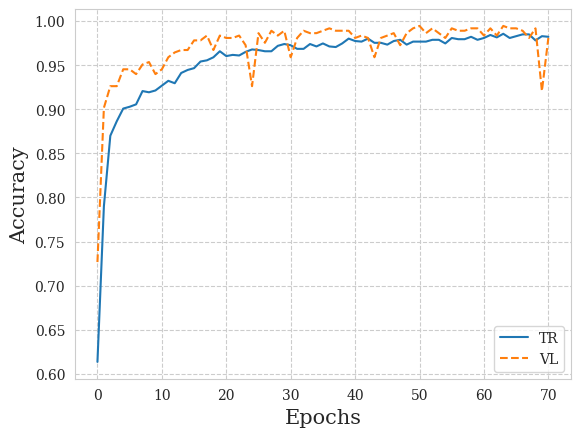

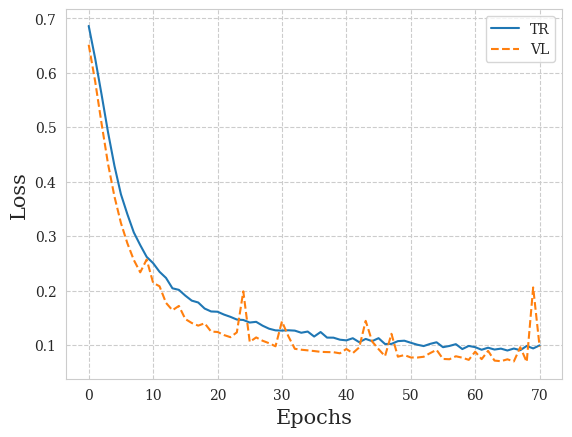

In [203]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [204]:
# performance on validation
y_pred = get_pred_sigmoid(model.predict(X_val))
print(classification_report(y_val, y_pred))

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       179
         1.0       0.96      1.00      0.98       187

    accuracy                           0.98       366
   macro avg       0.98      0.98      0.98       366
weighted avg       0.98      0.98      0.98       366



In [207]:
# retrain on all data (X_train)

keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(4, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0.001)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 0.1, momentum = 0.001),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

history = model.fit(X_train, y_train, epochs=70, batch_size=32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 1572      
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,577
Trainable params: 1,577
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
58/58 [==============================] - 1s 3ms/step - loss: 0.6830 - accuracy: 0.5903
Epoch 2/70
58/58 [==============================] - 0s 2ms/step - loss: 0.5904 - accuracy: 0.8107
Epoch 3/70
58/58 [==============================] - 0s 2ms/step - loss: 0.4914 - accuracy: 0.8939
Epoch 4/70
58/58 [==============================] - 0s 2ms/step - loss: 0.4072 - accuracy: 0.9032
Epoch 5/70
58/58 [==============================] - 0s 2ms

In [208]:
# performance on test
y_pred = get_pred_sigmoid(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       312
         1.0       0.95      0.96      0.95       312

    accuracy                           0.95       624
   macro avg       0.95      0.95      0.95       624
weighted avg       0.95      0.95      0.95       624



20/20 [==============================] - 0s 1ms/step


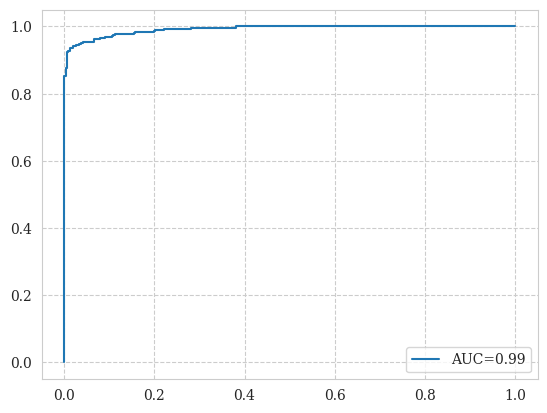

In [210]:
# ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.legend(loc=4)
plt.show()

#### Retraining on 10 random weight initalizations

In [50]:
accs = []
f1s = []
iter = 1
for i in random.sample(range(100), 10):
    print(f"Random weight initialization {iter}/10")
    keras.backend.clear_session()
    tf.random.set_seed(i)

    model = Sequential()
    model.add(Dense(4, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0.001)))
    model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

    model.compile(optimizer = SGD(learning_rate = 0.1, momentum = 0.001),
                      loss = "binary_crossentropy",
                      metrics = ["accuracy"])
    
    model.fit(X_train, y_train, epochs=70, batch_size=32, verbose=0)
    y_pred = get_pred_sigmoid(model.predict(X_test))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accs.append(acc)
    f1s.append(f1)
    iter += 1

print(f"\nAvg Accuracy: {np.mean(accs)}", f"Std Accuracy: {np.std(accs)}")
print(f"Avg Wt. F1: {np.mean(f1s)}", f"Std Wt. F1: {np.std(accs)}")

Random weight initialization 1/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 2/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 3/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 4/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 5/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 6/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 7/10
20/20 [==============================] - 0s 1ms/step
Random weight initialization 8/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 9/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 10/10
20/20 [==============================] - 0s 1ms/step

Avg Accuracy: 0.8405448717948719 Std Accuracy: 0.05888741675215746
Avg Wt. F1: 0.8345119976772175 Std Wt. F1: 0.0588874167521574

###**Target: Emotional Intensity**

#### Data Preparation

In [65]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "strong":
      new_array[i] = 1
  return new_array

In [66]:
X_train = df_train.drop("emotional_intensity", axis=1)
X_train = pd.get_dummies(X_train).to_numpy() #one-hot encoding + conversion into np array
y_train = label_encoder(df_train["emotional_intensity"])

In [67]:
X_test = df_test.drop("emotional_intensity", axis=1)
X_test = pd.get_dummies(X_test).to_numpy() #one-hot encoding + conversion into np array
y_test = label_encoder(df_test["emotional_intensity"])

In [68]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1828, 392) (1828,)
(624, 392) (624,)


In [69]:
# splitting VL
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, stratify=y_train, random_state=42)

In [70]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1279, 392) (1279,)
(549, 392) (549,)


####Model

In [255]:
# function to be passed to scikeras wrapper
def build_fn(n_hidden_units, hidden_activation, learning_rate, momentum, regularizer, lambd, initializer, output_activation): 
    keras.backend.clear_session()
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(n_hidden_units, 
                    activation = hidden_activation, 
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  regularizer(lambd),
                    kernel_initializer = initializer))
    
    model.add(Dense(1, 
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = SGD(learning_rate = learning_rate, momentum = momentum),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [256]:
# randomized search
model = KerasClassifier(build_fn,
                        hidden_activation = "sigmoid",
                        regularizer=L2,
                        initializer="glorot_normal",
                        output_activation="sigmoid",
                        random_state=42,
                        batch_size=32,
                        verbose=0
                        )

param_grid = {'model__n_hidden_units': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__momentum': [0, .001, .01, .1],
              'model__lambd': [0, .001, .01, .1],
              'epochs': [10, 20, 50, 100, 200]
              }

search = RandomizedSearchCV(model, 
                            param_grid, 
                            cv=StratifiedKFold(5, shuffle=True, random_state=42), 
                            verbose=1,
                            n_iter=50,
                            #n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train, y_train, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.7729680365296803 
Best params {'model__n_hidden_units': 64, 'model__momentum': 0.001, 'model__learning_rate': 1, 'model__lambd': 0, 'epochs': 200}


In [100]:
keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(64, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 1, momentum = 0.001),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                25152     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25,217
Trainable params: 25,217
Non-trainable params: 0
_________________________________________________________________


In [101]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=True)

history = model.fit(X_train2, y_train2, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/200
40/40 [==============================] - 1s 9ms/step - loss: 0.7744 - accuracy: 0.5410 - val_loss: 0.6728 - val_accuracy: 0.5938
Epoch 2/200
40/40 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.6083 - val_loss: 0.6197 - val_accuracy: 0.6685
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6474 - val_loss: 0.6371 - val_accuracy: 0.5811
Epoch 4/200
40/40 [==============================] - 0s 4ms/step - loss: 0.5854 - accuracy: 0.6833 - val_loss: 0.5673 - val_accuracy: 0.7067
Epoch 5/200
40/40 [==============================] - 0s 5ms/step - loss: 0.6136 - accuracy: 0.6693 - val_loss: 0.6202 - val_accuracy: 0.6576
Epoch 6/200
40/40 [==============================] - 0s 3ms/step - loss: 0.5724 - accuracy: 0.7068 - val_loss: 0.5755 - val_accuracy: 0.6995
Epoch 7/200
40/40 [==============================] - 0s 4ms/step - loss: 0.5660 - accuracy: 0.7052 - val_loss: 0.6000 - val_accuracy: 0.6958
Epoch 8/200
4

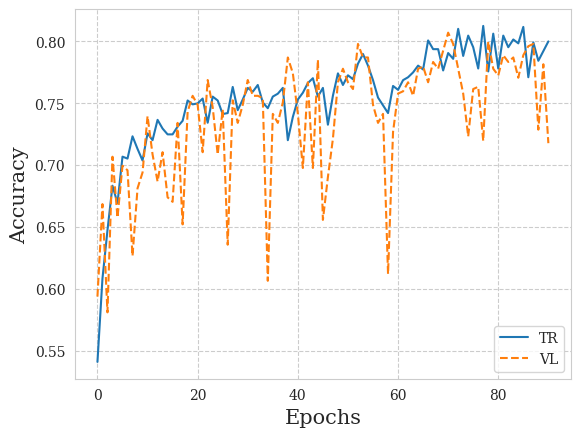

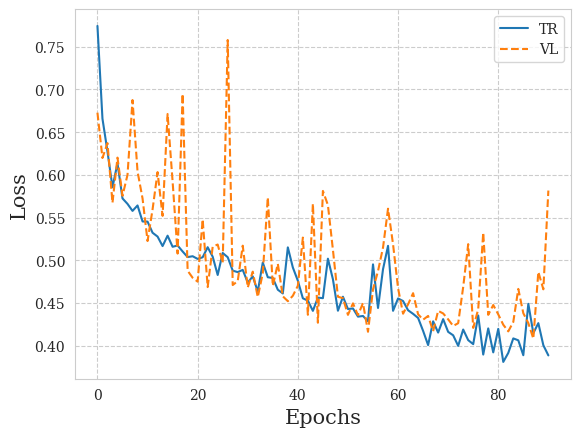

In [102]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [103]:
# performance on validation
y_pred = get_pred_sigmoid(model.predict(X_val))
print(classification_report(y_val, y_pred))

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79       296
         1.0       0.95      0.41      0.57       253

    accuracy                           0.72       549
   macro avg       0.80      0.70      0.68       549
weighted avg       0.79      0.72      0.69       549



In [104]:
# retrain on all data (X_train)
keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(64, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 1, momentum = 0.001),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

history = model.fit(X_train, y_train, epochs=91, batch_size=32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                25152     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25,217
Trainable params: 25,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/91
58/58 [==============================] - 1s 2ms/step - loss: 0.7558 - accuracy: 0.5574
Epoch 2/91
58/58 [==============================] - 0s 2ms/step - loss: 0.6488 - accuracy: 0.6411
Epoch 3/91
58/58 [==============================] - 0s 2ms/step - loss: 0.6251 - accuracy: 0.6466
Epoch 4/91
58/58 [==============================] - 0s 2ms/step - loss: 0.5919 - accuracy: 0.6811
Epoch 5/91
58/58 [==============================] - 0s 2

In [105]:
# performance on test 
y_pred = get_pred_sigmoid(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.73      0.88      0.80       336
         1.0       0.82      0.61      0.70       288

    accuracy                           0.76       624
   macro avg       0.77      0.75      0.75       624
weighted avg       0.77      0.76      0.75       624



20/20 [==============================] - 0s 2ms/step


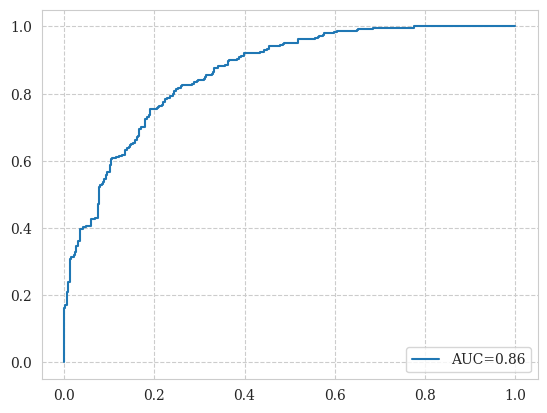

In [106]:
# ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.legend(loc=4)
plt.show()

#####Model with Adam

In [113]:
# function to be passed to scikeras wrapper
def build_fn(n_hidden_units, hidden_activation, learning_rate, regularizer, lambd, initializer, output_activation): 
    keras.backend.clear_session()
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(n_hidden_units, 
                    activation = hidden_activation, 
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  regularizer(lambd),
                    kernel_initializer = initializer))
    
    model.add(Dense(1, 
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = Adam(learning_rate = learning_rate),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [114]:
# randomized search
model = KerasClassifier(build_fn,
                        hidden_activation = "sigmoid",
                        regularizer=L2,
                        initializer="glorot_normal",
                        output_activation="sigmoid",
                        random_state=42,
                        batch_size=32,
                        verbose=0
                        )

param_grid = {'model__n_hidden_units': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__lambd': [0, .001, .01, .1],
              'epochs': [10, 20, 50, 100, 200]
              }

search = RandomizedSearchCV(model, 
                            param_grid, 
                            cv=StratifiedKFold(5, shuffle=True, random_state=42), 
                            verbose=1,
                            n_iter=50,
                            #n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train, y_train, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.7915787109813609 
Best params {'model__n_hidden_units': 16, 'model__learning_rate': 0.01, 'model__lambd': 0, 'epochs': 200}


In [192]:
keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(16, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = Adam(learning_rate = 0.01),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                6288      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,305
Trainable params: 6,305
Non-trainable params: 0
_________________________________________________________________


In [193]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=True)

history = model.fit(X_train2, y_train2, epochs=25, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/200
40/40 [==============================] - 1s 14ms/step - loss: 0.6847 - accuracy: 0.5864 - val_loss: 0.6423 - val_accuracy: 0.6375
Epoch 2/200
40/40 [==============================] - 0s 6ms/step - loss: 0.6089 - accuracy: 0.6959 - val_loss: 0.5830 - val_accuracy: 0.7213
Epoch 3/200
40/40 [==============================] - 0s 6ms/step - loss: 0.5749 - accuracy: 0.7162 - val_loss: 0.5627 - val_accuracy: 0.7213
Epoch 4/200
40/40 [==============================] - 0s 5ms/step - loss: 0.5552 - accuracy: 0.7224 - val_loss: 0.6109 - val_accuracy: 0.6721
Epoch 5/200
40/40 [==============================] - 0s 5ms/step - loss: 0.5348 - accuracy: 0.7279 - val_loss: 0.5211 - val_accuracy: 0.7413
Epoch 6/200
40/40 [==============================] - 0s 7ms/step - loss: 0.5036 - accuracy: 0.7639 - val_loss: 0.4941 - val_accuracy: 0.7614
Epoch 7/200
40/40 [==============================] - 0s 6ms/step - loss: 0.4812 - accuracy: 0.7639 - val_loss: 0.4756 - val_accuracy: 0.7650
Epoch 8/200


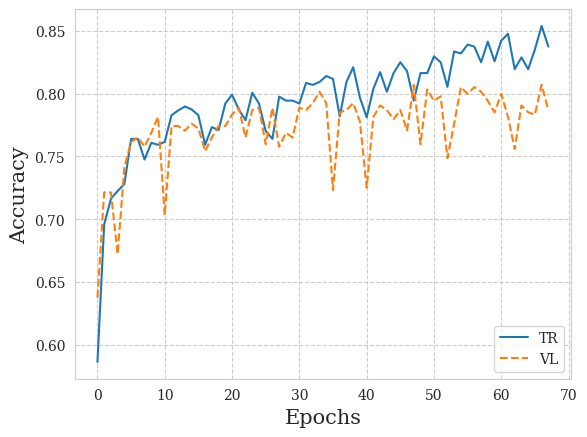

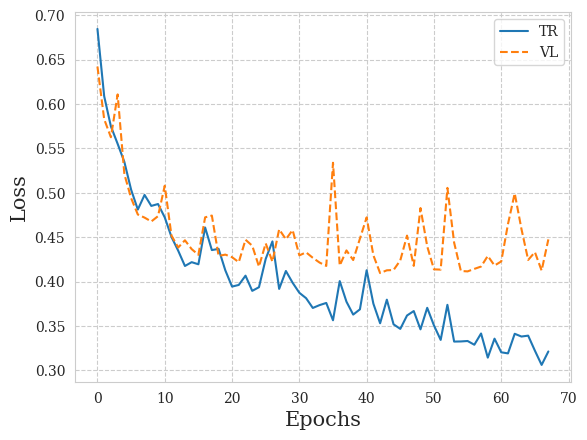

In [194]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

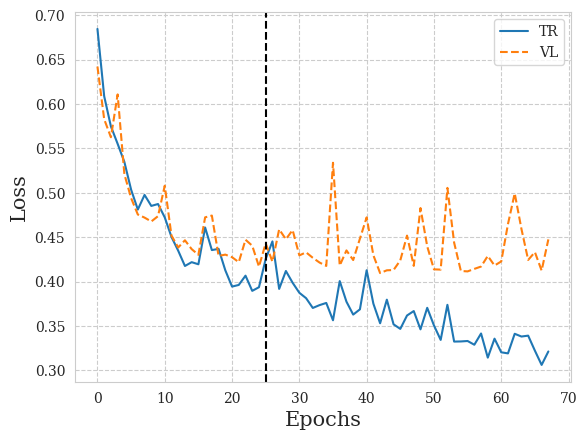

In [206]:
plt.plot(history.history['loss'], label='TR')
plt.plot(history.history['val_loss'], label='VL', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.axvline(25, linestyle='--', color="black")
plt.show()

In [195]:
# performance on validation
y_pred = get_pred_sigmoid(model.predict(X_val))
print(classification_report(y_val, y_pred))

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.75      0.91      0.82       296
         1.0       0.86      0.64      0.74       253

    accuracy                           0.79       549
   macro avg       0.80      0.78      0.78       549
weighted avg       0.80      0.79      0.78       549



In [207]:
# retraining on 25 epochs
keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(16, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = Adam(learning_rate = 0.01),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                6288      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,305
Trainable params: 6,305
Non-trainable params: 0
_________________________________________________________________


In [208]:
history = model.fit(X_train2, y_train2, epochs=25, batch_size=32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/25
40/40 [==============================] - 2s 16ms/step - loss: 0.7154 - accuracy: 0.5762 - val_loss: 0.6627 - val_accuracy: 0.6594
Epoch 2/25
40/40 [==============================] - 0s 6ms/step - loss: 0.6200 - accuracy: 0.6740 - val_loss: 0.5939 - val_accuracy: 0.7031
Epoch 3/25
40/40 [==============================] - 0s 6ms/step - loss: 0.5817 - accuracy: 0.7021 - val_loss: 0.5723 - val_accuracy: 0.7067
Epoch 4/25
40/40 [==============================] - 0s 6ms/step - loss: 0.5611 - accuracy: 0.7193 - val_loss: 0.5823 - val_accuracy: 0.6958
Epoch 5/25
40/40 [==============================] - 0s 7ms/step - loss: 0.5378 - accuracy: 0.7310 - val_loss: 0.5300 - val_accuracy: 0.7359
Epoch 6/25
40/40 [==============================] - 0s 7ms/step - loss: 0.5163 - accuracy: 0.7561 - val_loss: 0.5169 - val_accuracy: 0.7450
Epoch 7/25
40/40 [==============================] - 0s 6ms/step - loss: 0.4983 - accuracy: 0.7647 - val_loss: 0.4954 - val_accuracy: 0.7341
Epoch 8/25
40/40 [=

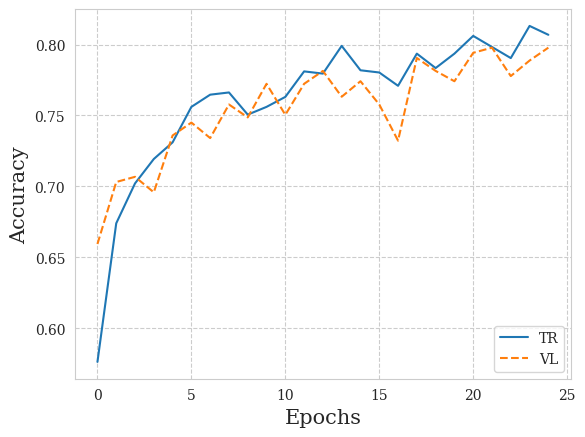

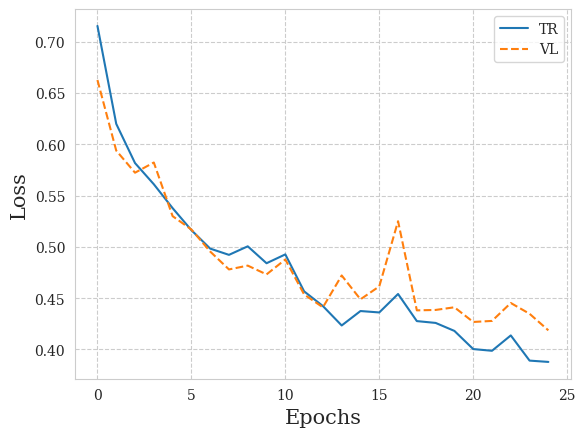

In [210]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [209]:
# performance on validation
y_pred = get_pred_sigmoid(model.predict(X_val))
print(classification_report(y_val, y_pred))

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       296
         1.0       0.78      0.78      0.78       253

    accuracy                           0.80       549
   macro avg       0.80      0.80      0.80       549
weighted avg       0.80      0.80      0.80       549



In [171]:
# retrain on all data (X_train)
keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(64, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = Adam(learning_rate = 0.01),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

history = model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                25152     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25,217
Trainable params: 25,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
58/58 [==============================] - 1s 3ms/step - loss: 0.6554 - accuracy: 0.6395
Epoch 2/25
58/58 [==============================] - 0s 3ms/step - loss: 0.5715 - accuracy: 0.7095
Epoch 3/25
58/58 [==============================] - 0s 3ms/step - loss: 0.5228 - accuracy: 0.7396
Epoch 4/25
58/58 [==============================] - 0s 3ms/step - loss: 0.4811 - accuracy: 0.7527
Epoch 5/25
58/58 [==============================] - 0s 3

In [172]:
# performance on test 
y_pred = get_pred_sigmoid(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.79      0.87      0.82       336
         1.0       0.82      0.73      0.77       288

    accuracy                           0.80       624
   macro avg       0.80      0.80      0.80       624
weighted avg       0.80      0.80      0.80       624



20/20 [==============================] - 0s 2ms/step


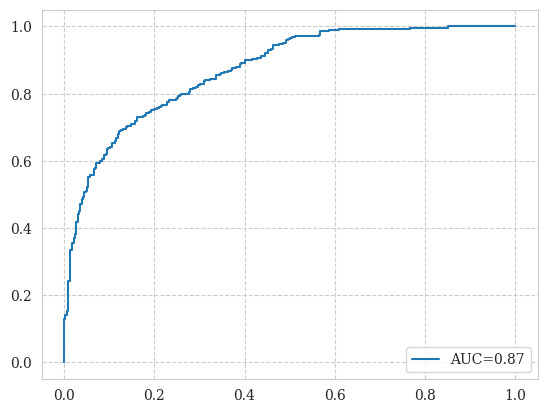

In [160]:
# ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.legend(loc=4)
plt.show()

#### Retraining on 10 random weight initalizations

In [71]:
accs = []
f1s = []
iter = 1
for i in random.sample(range(100), 10):
    print(f"Random weight initialization {iter}/10")
    keras.backend.clear_session()
    tf.random.set_seed(i)

    model = Sequential()
    model.add(Dense(64, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
    model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

    model.compile(optimizer = Adam(learning_rate = 0.01),
                      loss = "binary_crossentropy",
                      metrics = ["accuracy"])
    
    model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)
    y_pred = get_pred_sigmoid(model.predict(X_test))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accs.append(acc)
    f1s.append(f1)
    iter += 1

print(f"\nAvg Accuracy: {np.mean(accs)}", f"Std Accuracy: {np.std(accs)}")
print(f"Avg Wt. F1: {np.mean(f1s)}", f"Std Wt. F1: {np.std(accs)}")

Random weight initialization 1/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 2/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 3/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 4/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 5/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 6/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 7/10
20/20 [==============================] - 0s 1ms/step
Random weight initialization 8/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 9/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 10/10
20/20 [==============================] - 0s 2ms/step

Avg Accuracy: 0.759775641025641 Std Accuracy: 0.029796058523742622
Avg Wt. F1: 0.7557906555346486 Std Wt. F1: 0.0297960585237426

###**Target: Emotion**

#### Data Preparation

In [16]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "calm":
      new_array[i] = 1
    elif array[i] == "happy":
      new_array[i] = 2
    elif array[i] == "sad":
      new_array[i] = 3
    elif array[i] == "angry":
      new_array[i] = 4
    elif array[i] == "fearful":
      new_array[i] = 5
    elif array[i] == "disgust":
      new_array[i] = 6
    elif array[i] == "surprised":
      new_array[i] = 7
  return new_array

In [17]:
X_train = df_train.drop("emotion", axis=1)
X_train = pd.get_dummies(X_train).to_numpy() #one-hot encoding + conversion into np array
#label_encoder = LabelEncoder()
y_train = label_encoder(df_train["emotion"])

In [18]:
X_test = df_test.drop("emotion", axis=1)
X_test = pd.get_dummies(X_test).to_numpy() #one-hot encoding + conversion into np array
#label_encoder = LabelEncoder()
y_test = label_encoder(df_test["emotion"])

In [19]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1828, 386) (1828,)
(624, 386) (624,)


In [20]:
np.unique(y_train)

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [21]:
# splitting VL
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, stratify=y_train, random_state=10)

In [22]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1279, 386) (1279,)
(549, 386) (549,)


####Model

In [23]:
# function to be passed to scikeras wrapper

def build_fn(n_hidden_units, hidden_activation, learning_rate, momentum, regularizer, lambd, initializer, output_activation): 
    keras.backend.clear_session()
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(n_hidden_units, 
                    activation = hidden_activation, 
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  regularizer(lambd),
                    kernel_initializer = initializer))
    
    model.add(Dense(8, 
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = SGD(learning_rate = learning_rate, momentum = momentum),
                  loss = SparseCategoricalCrossentropy(),
                  metrics = ["accuracy"])
    return model

In [25]:
# randomized search
model = KerasClassifier(build_fn,
                        hidden_activation = "sigmoid",
                        regularizer=L2,
                        initializer="glorot_normal",
                        output_activation="softmax",
                        random_state=42,
                        batch_size=32,
                        verbose=0
                        )

param_grid = {'model__n_hidden_units': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__momentum': [0, .001, .01, .1],
              'model__lambd': [0, .001, .01, .1],
              'epochs': [10, 20, 50, 100, 200]
              }

search = RandomizedSearchCV(model, 
                            param_grid, 
                            cv=StratifiedKFold(5, shuffle=True, random_state=42), 
                            verbose=1,
                            n_iter=50,
                            #n_jobs=-1,
                            scoring='accuracy',
                            error_score='raise')

search.fit(X_train, y_train, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.5694632831798787 
Best params {'model__n_hidden_units': 32, 'model__momentum': 0.001, 'model__learning_rate': 1, 'model__lambd': 0, 'epochs': 200}


In [33]:
keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(32, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(8, activation="softmax", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 1, momentum = 0.001),
                  loss = SparseCategoricalCrossentropy(),
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                12384     
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 12,648
Trainable params: 12,648
Non-trainable params: 0
_________________________________________________________________


In [34]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=True)

history = model.fit(X_train2, y_train2, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/200
40/40 [==============================] - 4s 38ms/step - loss: 2.0648 - accuracy: 0.1478 - val_loss: 2.0090 - val_accuracy: 0.1967
Epoch 2/200
40/40 [==============================] - 1s 25ms/step - loss: 1.9432 - accuracy: 0.2260 - val_loss: 2.1699 - val_accuracy: 0.1712
Epoch 3/200
40/40 [==============================] - 2s 38ms/step - loss: 1.8368 - accuracy: 0.2619 - val_loss: 2.0508 - val_accuracy: 0.1730
Epoch 4/200
40/40 [==============================] - 1s 27ms/step - loss: 1.8507 - accuracy: 0.2408 - val_loss: 1.9318 - val_accuracy: 0.2259
Epoch 5/200
40/40 [==============================] - 0s 8ms/step - loss: 1.7654 - accuracy: 0.2869 - val_loss: 1.7425 - val_accuracy: 0.2787
Epoch 6/200
40/40 [==============================] - 0s 6ms/step - loss: 1.7450 - accuracy: 0.2862 - val_loss: 1.6769 - val_accuracy: 0.3242
Epoch 7/200
40/40 [==============================] - 0s 5ms/step - loss: 1.7168 - accuracy: 0.2932 - val_loss: 1.7628 - val_accuracy: 0.3042
Epoch 8/2

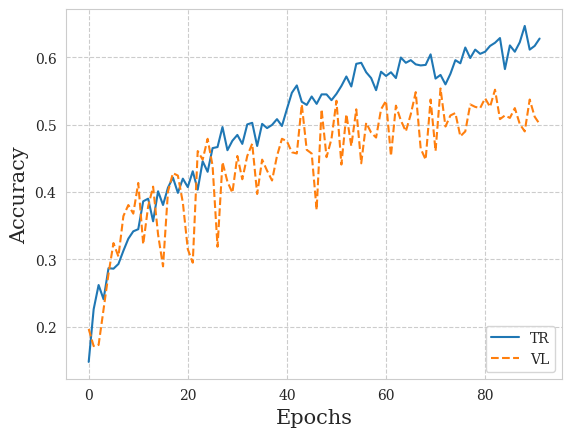

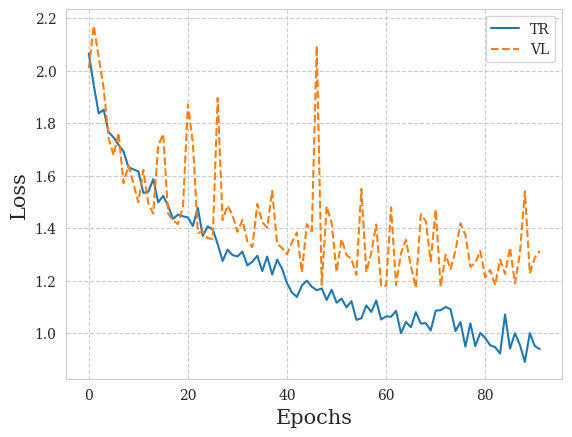

In [35]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [37]:
# performance on validation
y_pred = get_pred_softmax(model.predict(X_val))
print(classification_report(y_val, y_pred))

18/18 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.62      0.12      0.20        42
         1.0       0.69      0.50      0.58        84
         2.0       0.41      0.52      0.46        84
         3.0       0.36      0.55      0.43        84
         4.0       0.70      0.87      0.77        84
         5.0       0.83      0.23      0.36        84
         6.0       0.59      0.39      0.47        44
         7.0       0.33      0.67      0.45        43

    accuracy                           0.50       549
   macro avg       0.57      0.48      0.46       549
weighted avg       0.58      0.50      0.49       549



In [38]:
# retrain on all data (X_train) 
keras.backend.clear_session()
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(32, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(8, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 1, momentum = 0.001),
                  loss = SparseCategoricalCrossentropy(),
                  metrics = ["accuracy"])
model.summary()

history = model.fit(X_train, y_train, epochs=92, batch_size=32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                12384     
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 12,648
Trainable params: 12,648
Non-trainable params: 0
_________________________________________________________________
Epoch 1/92
58/58 [==============================] - 1s 2ms/step - loss: 2.0365 - accuracy: 0.2030
Epoch 2/92
58/58 [==============================] - 0s 3ms/step - loss: 1.8898 - accuracy: 0.2358
Epoch 3/92
58/58 [==============================] - 0s 3ms/step - loss: 1.8125 - accuracy: 0.2505
Epoch 4/92
58/58 [==============================] - 0s 3ms/step - loss: 1.7507 - accuracy: 0.2757
Epoch 5/92
58/58 [==============================] - 0s 3

In [40]:
# performance on test with only train2
y_pred = get_pred_softmax(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        48
         1.0       1.00      0.03      0.06        96
         2.0       0.35      0.29      0.32        96
         3.0       0.37      0.48      0.42        96
         4.0       0.64      0.68      0.66        96
         5.0       0.83      0.16      0.26        96
         6.0       0.22      1.00      0.36        48
         7.0       0.38      0.60      0.46        48

    accuracy                           0.38       624
   macro avg       0.47      0.40      0.32       624
weighted avg       0.54      0.38      0.33       624

